# Evaluate Translation Invariance

running
(1, 0, 0, 0)
(0, 1, 0, 0)
(0, 0, 1, 0)
(0, 0, 0, 1)
{(1, 0, 0, 0): {'mean': 0.6514465988159179, 'absolute mean': 3.950968906021118, 'std dev': 5.039225358915352}, (0, 1, 0, 0): {'mean': 0.9301855913162231, 'absolute mean': 3.7623562482833863, 'std dev': 4.774875928340922}, (0, 0, 1, 0): {'mean': 0.6772099828720093, 'absolute mean': 3.913915834617615, 'std dev': 5.05499771482893}, (0, 0, 0, 1): {'mean': 0.8264396282196045, 'absolute mean': 3.8321482643127442, 'std dev': 4.947782933111632}}


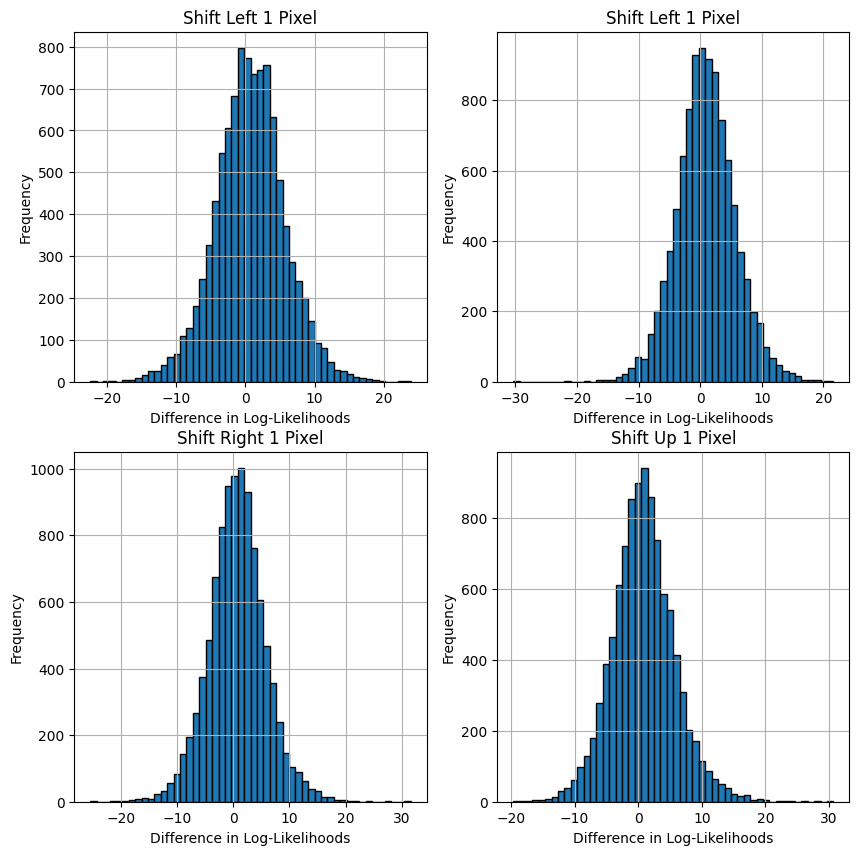

In [8]:
# TODO: maybe store translation_lls and statistics as an artifact?
print('running')
import os
import torch
from torch.utils.data import DataLoader
from joblib import dump
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from util import translate_img_batch, cross_entropy_loss_fn
from data import load_data
from train import evaluation
import statistics
import matplotlib.pyplot as plt
import yaml

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

_, _, test_data = load_data('mnist', binarize=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

result_dir = 'results_made/translation_lls'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'regularized'
model = torch.load('models/made_regularized.model').to(device)
model.eval()

translations = [(1,0,0,0), (0,1,0,0), (0,0,1,0), (0,0,0,1)] #, (1,1,0,0), (0,0,1,1), (2,1,0,0), (1,2,0,0), (0,0,1,2), (0,0,2,1), (2,2,0,0), (0,0,2,2)]
lls_translation = {}
for translation in translations:
    print(translation)
    shift_left, shift_down, shift_right, shift_up = translation
    lls = []
    for img in test_loader:
        translated_img = translate_img_batch(img, shift_left, shift_down, shift_right, shift_up)
        preds = model.forward(img)
        translated_preds = model.forward(translated_img)
        ll = -(cross_entropy_loss_fn(img, preds) - cross_entropy_loss_fn(translated_img, translated_preds))
        lls.append(ll)
    lls_translation[translation] = lls

with open(result_dir + '/' + f'{name}.pkl', 'wb') as file:
    dump(lls_translation, file)

translations_dic = {translation: None for translation in translations}
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, translation in enumerate(translations):
    values = [tensor.item() for tensor in lls_translation[translation]]
    translations_dic[translation] = {'mean': statistics.mean(values), 
                                     'absolute mean': sum([abs(x) for x in values])/len(values), 
                                     'std dev': statistics.stdev(values)}
    ax = axes[i // 2, i % 2]
    ax.hist(values, bins=50, edgecolor='black')
    ax.set_xlabel('Difference in Log-Likelihoods')
    ax.set_ylabel('Frequency')
    if i == 0:
        ax.set_title(f'Shift Left 1 Pixel')
    elif i == 1:
        ax.set_title(f'Shift Left 1 Pixel')
    elif i == 2:
        ax.set_title(f'Shift Right 1 Pixel')
    else:
        ax.set_title(f'Shift Up 1 Pixel')
    ax.grid(True)

with open(result_dir + '/' + 'statistics_best.yaml', 'w') as file:
    yaml.dump(translations_dic, file)
print(translations_dic)

# Samples

running
FINAL LOSS: nll=1.353240581512451
test loss: 86.60739721679687


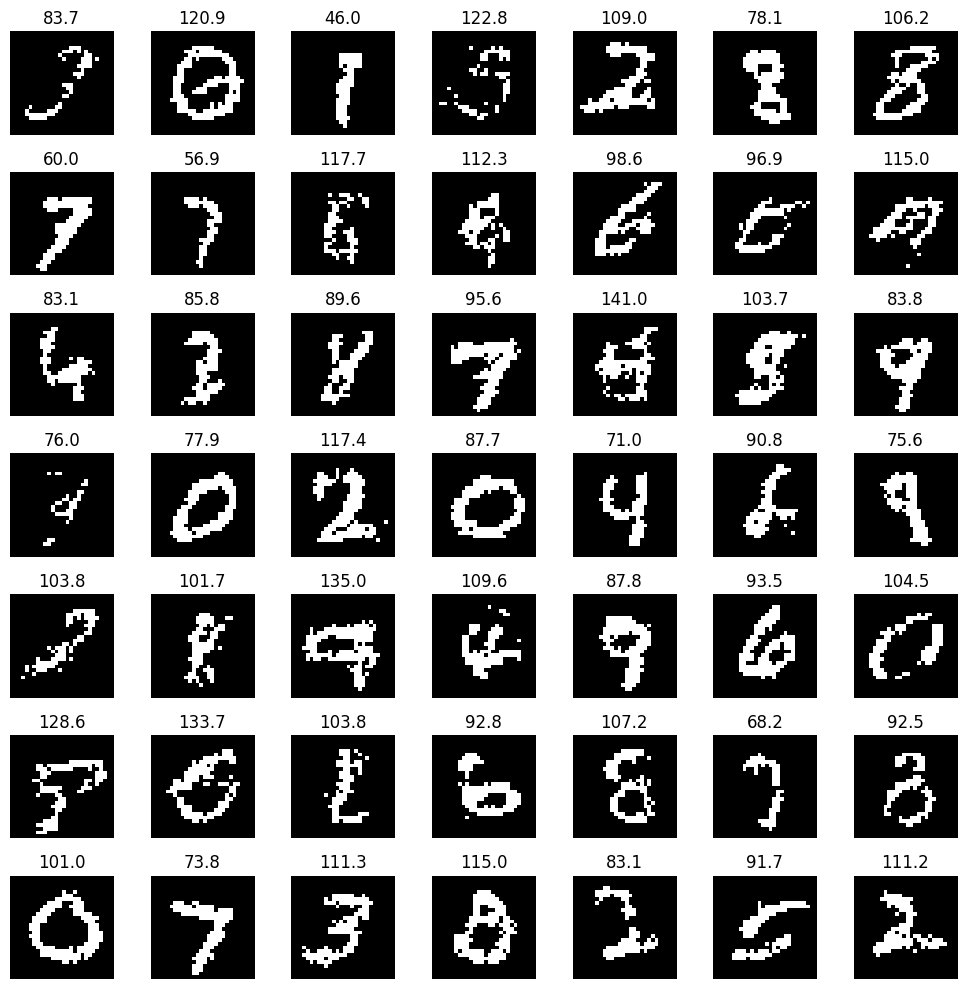

In [7]:
import torch

print('running')
import os
import torch
from torch.utils.data import DataLoader
from joblib import dump
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from util import translate_img_batch, cross_entropy_loss_fn
from data import load_data
from train import evaluation
import statistics
import matplotlib.pyplot as plt
import yaml

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

_, _, test_data = load_data('mnist', binarize=True) # Remove val_data
batch_size = 64
test_loader = DataLoader(test_data, batch_size=batch_size)

model = torch.load('models/made_vanilla.model') # Change this to the one from model registry
model.eval()
test_loss = evaluation(test_loader, cross_entropy_loss_fn, model_best = model)
print(f"test loss: {test_loss * batch_size}")
x = model.sample(49)#.detach().numpy()
fig1, axes1 = plt.subplots(7, 7, figsize=(10, 10))
for i in range(49):
    ax = axes1[i // 7, i % 7]
    ax.imshow(x.detach().numpy()[i].reshape(28,28), cmap = 'gray')
    preds = model.forward(x[i])
    nll = cross_entropy_loss_fn(x[i], preds)
    ax.set_title(f"{round(nll.item(),1)}")
    ax.axis('off')
fig1.tight_layout()
plt.show()

# Sample Quality (KID/FID/Precision/Recall)

In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance

_, _, test_data = load_data('mnist', binarize=True, eval = True, val = False)
test_loader = DataLoader(test_data, batch_size=100)

metric = FrechetInceptionDistance(feature=768)
values = [ ]
for i, batch in enumerate(test_loader):
     metric.update(next(iter(test_loader)).to(torch.uint8).repeat(1,3,1,1), real=True)
     metric.update(model.sample(100).reshape(100,1,28,28).to(torch.uint8).repeat(1,3,1,1), real=False)
     val = metric.compute().item()
     values.append(val)
     print(f'{i}:', val)
     metric.reset()
fig_, ax_ = metric.plot(values)